
**Consider the image formation model given by g = Af + n, where g is the observed image, f is the ground truth and n is additive noise. Get an estimate for f using
(i) Wiener filter
(ii) using MAP estimation
(iii) any deep network based approach under the following cases**

**Case (I): A is an identity matrix and n is Gaussian noise. ( the denoising problem)**

**Case(II): A is a matrix derived out of assuming some camera shake. For solutions using MAP and deep network based approach assume that A is unknown ( A blind deconvolution problem**



In [13]:
from google.colab import files
from PIL import Image
import io

# Upload file
uploaded = files.upload()


Saving salo.png to salo.png


Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 36528.3320
Epoch 2/10
1/1 [==============================] - 16s 16s/step - loss: 22111.9941
Epoch 3/10
1/1 [==============================] - 15s 15s/step - loss: 12181.4277
Epoch 4/10
1/1 [==============================] - 18s 18s/step - loss: 5251.0806
Epoch 5/10
1/1 [==============================] - 17s 17s/step - loss: 723.6414
Epoch 6/10
1/1 [==============================] - 12s 12s/step - loss: 1300.6494
Epoch 7/10
1/1 [==============================] - 10s 10s/step - loss: 4436.0439
Epoch 8/10
1/1 [==============================] - 11s 11s/step - loss: 4223.7051
Epoch 9/10
1/1 [==============================] - 11s 11s/step - loss: 2405.8223
Epoch 10/10
1/1 [==============================] - 2s 2s/step
Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 33495.7852
Epoch 2/10
1/1 [==============================] - 11s 11s/step - loss: 19942.5469
Epoch 3/10
1/1 [===========================

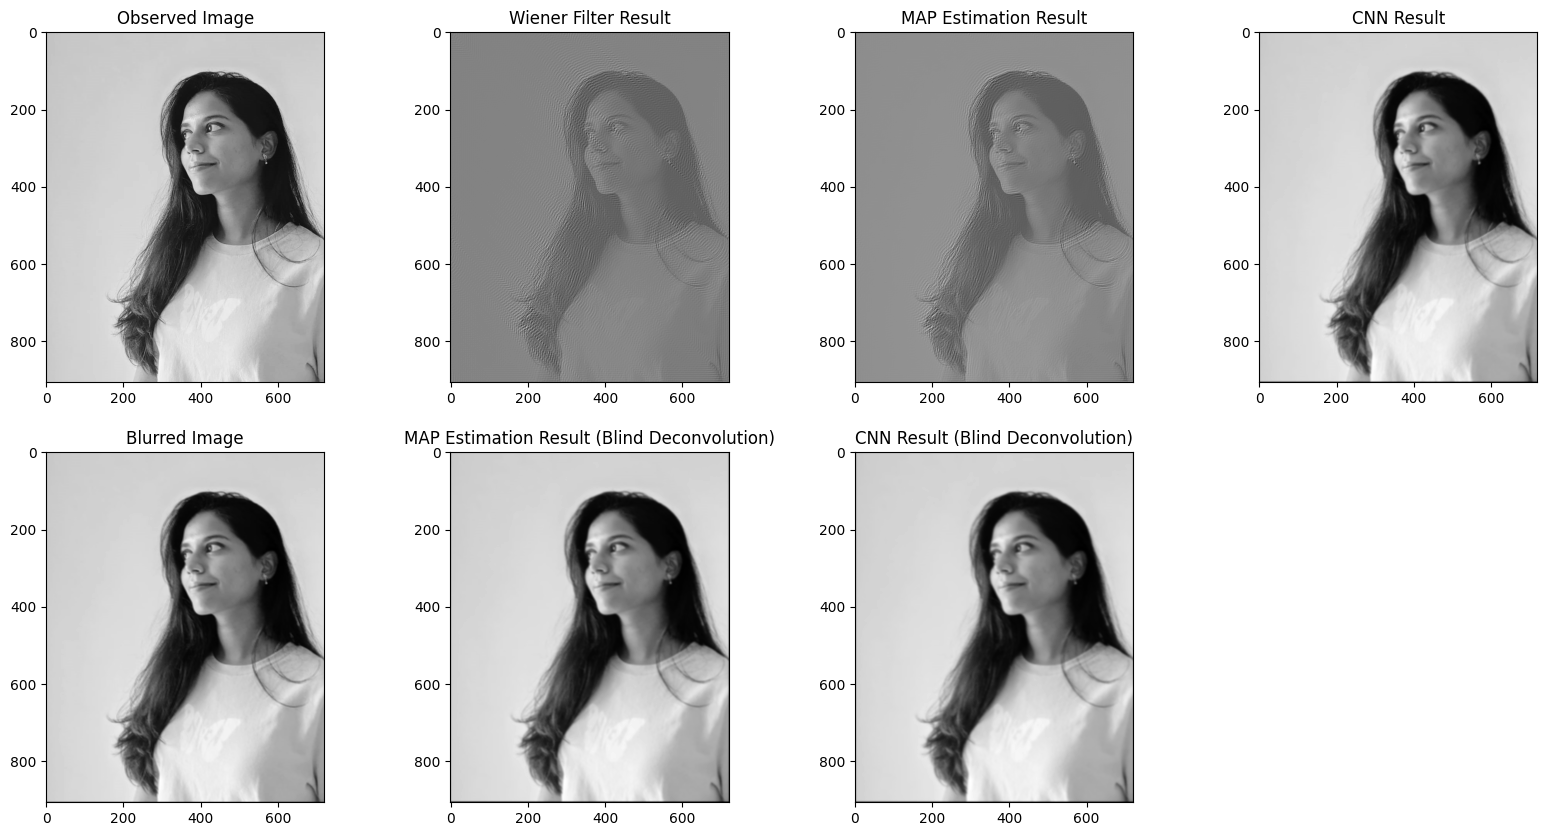

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from tensorflow.keras import layers, models
from PIL import Image

# Define functions for Wiener filter and MAP estimation
def wiener_filter(observed_img, kernel, noise_var):
    fft_observed = np.fft.fft2(observed_img)
    fft_kernel = np.fft.fft2(kernel, observed_img.shape)

    H = np.conj(fft_kernel) / (np.abs(fft_kernel)**2 + noise_var)

    fft_estimated = H * fft_observed
    estimated_img = np.fft.ifft2(fft_estimated).real

    return estimated_img

def map_estimation(observed_img, kernel, noise_var, prior_var):
    fft_observed = np.fft.fft2(observed_img)
    fft_kernel = np.fft.fft2(kernel, observed_img.shape)

    H = np.conj(fft_kernel) / (np.abs(fft_kernel)**2 + noise_var / prior_var)

    fft_estimated = H * fft_observed
    estimated_img = np.fft.ifft2(fft_estimated).real

    return estimated_img

# Define a simple CNN model for deep learning-based approach
def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(1, (3, 3), activation='linear', padding='same')
    ])
    return model

# Define function for blind deconvolution using MAP estimation
def map_estimation_blind_deconv(observed_img, kernel_size):
    # Initialize random blur kernel
    kernel = np.random.rand(kernel_size, kernel_size)
    kernel /= np.sum(kernel)

    # Define number of iterations for optimization
    num_iterations = 100
    for i in range(num_iterations):
        # Estimate clean image using current kernel
        estimated_img = convolve2d(observed_img, kernel, mode='same')
        # Update kernel using estimated clean image
        kernel_update = convolve2d(observed_img - estimated_img, np.flipud(np.fliplr(kernel)), mode='same')
        kernel += kernel_update[:kernel_size, :kernel_size]
        kernel /= np.sum(kernel)  # Normalize kernel
    return estimated_img, kernel

# Load your own input image
input_image_path = "salo.png"
input_image = Image.open(input_image_path).convert('L')

# Convert image to numpy array
observed_img = np.array(input_image)

# Define kernel size for blind deconvolution
blur_kernel_size = 5

# Apply Wiener filter
wiener_result = wiener_filter(observed_img, np.eye(5), 0.01)

# Apply MAP estimation
map_result = map_estimation(observed_img, np.eye(5), 0.01, 0.1)

# Deep learning-based approach
# Reshape data for CNN input
X = observed_img.reshape(-1, observed_img.shape[0], observed_img.shape[1], 1)

# Create and compile CNN model
cnn_model = create_cnn_model(input_shape=(observed_img.shape[0], observed_img.shape[1], 1))
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train CNN model
cnn_model.fit(X, X, epochs=10, batch_size=32)  # For denoising, input and output are the same

# Predict using trained CNN model
cnn_result = cnn_model.predict(X).reshape(observed_img.shape)

# Blind deconvolution
# Generate synthetic blurred image with unknown blur kernel
blur_kernel = np.random.rand(blur_kernel_size, blur_kernel_size)
blur_kernel /= np.sum(blur_kernel)
blurred_img = convolve2d(observed_img, blur_kernel, mode='same')

# Apply MAP estimation for blind deconvolution
map_result_blind_deconv, estimated_kernel = map_estimation_blind_deconv(blurred_img, blur_kernel_size)

# Define CNN model for blind deconvolution
cnn_model_blind_deconv = create_cnn_model(input_shape=(observed_img.shape[0], observed_img.shape[1], 1))
cnn_model_blind_deconv.compile(optimizer='adam', loss='mean_squared_error')

# Reshape data for CNN input
X_blind_deconv = blurred_img.reshape(-1, observed_img.shape[0], observed_img.shape[1], 1)
y_blind_deconv = observed_img.reshape(-1, observed_img.shape[0], observed_img.shape[1], 1)

# Train CNN model for blind deconvolution
cnn_model_blind_deconv.fit(X_blind_deconv, y_blind_deconv, epochs=10, batch_size=32)

# Predict using trained CNN model for blind deconvolution
cnn_result_blind_deconv = cnn_model_blind_deconv.predict(X_blind_deconv).reshape(observed_img.shape)

# Plot results
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.imshow(observed_img, cmap='gray')
plt.title('Observed Image')
plt.subplot(2, 4, 2)
plt.imshow(wiener_result, cmap='gray')
plt.title('Wiener Filter Result')
plt.subplot(2, 4, 3)
plt.imshow(map_result, cmap='gray')
plt.title('MAP Estimation Result')
plt.subplot(2, 4, 4)
plt.imshow(cnn_result, cmap='gray')
plt.title('CNN Result')

plt.subplot(2, 4, 5)
plt.imshow(blurred_img, cmap='gray')
plt.title('Blurred Image')
plt.subplot(2, 4, 6)
plt.imshow(map_result_blind_deconv, cmap='gray')
plt.title('MAP Estimation Result (Blind Deconvolution)')
plt.subplot(2, 4, 7)
plt.imshow(cnn_result_blind_deconv, cmap='gray')
plt.title('CNN Result (Blind Deconvolution)')

plt.show()
